## Import Libraries

In [35]:
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


## Word2Vec

In [36]:
model = Word2Vec.load("model.bin")

In [37]:
word_vector = model.wv['drugs']  
print(word_vector)

[-0.8893885   3.509865   -1.1649253   0.37511265 -0.88337153 -0.4662615
 -2.0432796   0.831412    0.9755035   2.410084   -0.10849394 -1.883863
 -1.8248148   2.787937   -1.5032511  -0.41665402  1.5385026  -2.6455333
  0.88204783 -2.4548516   0.28260392  0.29351878  1.6321409  -0.4623531
  3.0121746   1.7517947  -0.93291616  2.4090998  -2.6232476   2.6895576
 -1.4975549   1.7319837   0.53198904 -1.9691468   0.34599096  2.0888896
  1.3771238  -0.36920312 -1.5409142  -0.74937415 -0.366376   -1.2307234
  0.63413936  2.5449655   2.1690147   1.1890692   0.48812467  0.8564312
  0.5036675  -0.70403475  0.29097202 -0.718549    2.6806014   0.0149628
 -0.6384842  -1.7613885  -0.72271276  0.86269784  1.0201939   0.5107717
  0.48290032 -2.7008164   1.2013719   0.78600764  0.17969471 -2.3018062
  0.8550455   2.644128   -1.0167307  -0.19610241 -1.2685068   2.743304
 -2.0060565  -2.3079863  -1.2158242   1.782713   -2.1657627  -2.2557726
  0.09969022 -0.7657959  -1.5388653  -1.6568203  -1.2926213  -1.51

In [38]:
similar_words = model.wv.most_similar('drugs', topn=10) 
print(similar_words)

[('agents', 0.8188880085945129), ('medications', 0.7854257225990295), ('drug', 0.7784940600395203), ('medicaments', 0.7297026515007019), ('aeds', 0.7187907099723816), ('medicines', 0.7049173712730408), ('<abstracttext>drugs', 0.704905092716217), ('antiepileptics', 0.702126681804657), ('chemotherapeutics', 0.699542760848999), ('psychotropics', 0.6861249804496765)]


In [39]:
similarity = model.wv.similarity('girl', 'boy')  
print(similarity)

0.975124


In [40]:
result_vector = model.wv['king'] - model.wv['man'] + model.wv['woman']
similar_to_result = model.wv.most_similar(positive=[result_vector], topn=10)
print(similar_to_result)

[('king', 0.7105740308761597), ('woman', 0.6388511657714844), ('memorial', 0.6239749789237976), ('margaret', 0.6186293363571167), ('princess', 0.618542492389679), ('mary', 0.6077402830123901), ('edward', 0.5938355922698975), ('george', 0.5795809030532837), ('groote', 0.5793609023094177), ('radiumhemmet', 0.5734840035438538)]


## Dataset

Function to parse drug entities from a given XML file

In [41]:
def parse_drug_entities(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    drugs = set()
    
    for entity in root.findall(".//entity"):
        if entity.attrib.get('type') == 'drug' or entity.attrib.get('type') == 'brand' or entity.attrib.get('type') == 'drug_n':
            drugs.add(entity.attrib.get('text'))
    
    return drugs

Function to parse drug entities from XML files in a given directory


In [42]:
def extract_unique_drug_entities(directory):
    unique_drug_entities = set()
    for file_name in os.listdir(directory):
        if file_name.endswith('.xml'):
            file_path = os.path.join(directory, file_name)
            drug_entities = parse_drug_entities(file_path)  
            unique_drug_entities.update(drug_entities)
    return unique_drug_entities


Extract unique drug entities for training and testing datasets

In [43]:
train_dirs = ['../DDICorpus/Train/DrugBank', '../DDICorpus/Train/MedLine']
test_dirs = ['../DDICorpus/Test/Test for DDI Extraction task/DrugBank', '../DDICorpus/Test/Test for DDI Extraction task/MedLine']


all_drug_entities = set()
all_drug_entities_test = set()

for directory in train_dirs:
    all_drug_entities.update(extract_unique_drug_entities(directory))

for directory in test_dirs:
    all_drug_entities_test.update(extract_unique_drug_entities(directory))

# Print results
print(f"Total unique drug entities (train): {len(all_drug_entities)}")
print(all_drug_entities)

print(f"Total unique drug entities (test): {len(all_drug_entities_test)}")
print(all_drug_entities_test)


Total unique drug entities (train): 2085
{'Trimethoprim', 'eplerenone', 'atovaquone', 'Trileptal', 'aspirins', 'filipin', 'naproxen', 'adrenaline', 'Cobalt', 'promoter', 'Lopinavir', 'veratrum alkaloids', 'CBZ', 'cloxacillin', 'Furadantin', 'lidocaine', 'PRECEDEX', 'cabergoline', 'bexarotene', 'tenofovir disoproxil fumarate', 'Allopurinol', 'co-trimoxazole', 'prochlorperazine', 'letrozole', 'mesoridazine', 'Clostridium difficile toxin A', 'glipizide', 'PROSCAR', 'oxymetazoline', 'BARACLUDE', 'cefamandole', 'medroxyprogesterone', 'S warfarin', 'coumaphos', 'Septra', 'ADL-8-2698', 'AZOPT', 'DIDREX', 'azathioprine', 'ALFENTA', 'dipyridamole', 'glibenclamide', 'cisplatin', 'ethinylestradiol', 'Cerivastatin', 'tamsulosin', 'ouabain', 'cilostazol', 'ERYTHROMYCIN', 'denileukin diftitox', 'Resveratrol', 'sulfur', 'sildenafil', 'COPEGUS', 'meperidine', 'dopamine HCl', 'minocycline', 'Maalox', 'doxazosin mesylate', 'Fentanyl', 'Accutane', 'nitrogen mustard', 'FLEXERIL', 'Neomycin', 'Isoprotereno

Function to extract drug vectors from the model for a given set of drug entities


In [44]:
def get_drug_vectors(drug_entities, model):
    drug_vectors = {}
    for drug in drug_entities:
        if drug in model.wv:
            drug_vectors[drug] = model.wv[drug]
            print(f"Vector for {drug} found in the model.")
        else:
            print(f"Vector for {drug} not found in the model.")
    return drug_vectors

Get vectors for training and testing drug entities

In [45]:
drug_vectors = get_drug_vectors(all_drug_entities, model)
drug_vectors_test = get_drug_vectors(all_drug_entities_test, model)

Vector for Trimethoprim not found in the model.
Vector for eplerenone not found in the model.
Vector for atovaquone found in the model.
Vector for Trileptal not found in the model.
Vector for aspirins found in the model.
Vector for filipin found in the model.
Vector for naproxen found in the model.
Vector for adrenaline found in the model.
Vector for Cobalt not found in the model.
Vector for promoter found in the model.
Vector for Lopinavir not found in the model.
Vector for veratrum alkaloids not found in the model.
Vector for CBZ not found in the model.
Vector for cloxacillin found in the model.
Vector for Furadantin not found in the model.
Vector for lidocaine found in the model.
Vector for PRECEDEX not found in the model.
Vector for cabergoline found in the model.
Vector for bexarotene not found in the model.
Vector for tenofovir disoproxil fumarate not found in the model.
Vector for Allopurinol not found in the model.
Vector for co-trimoxazole found in the model.
Vector for prochl

In [46]:
drug_vectors_df = pd.DataFrame.from_dict(drug_vectors, orient='index')
drug_vectors_df_test = pd.DataFrame.from_dict(drug_vectors_test, orient='index')

In [47]:
# Function to parse DDI relations from XML files in a given directory
def parse_ddi_relations_from_directory(directory):
    drug_pairs = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.xml'):
            file_path = os.path.join(directory, file_name)
            drug_pairs.extend(parse_ddi_relations(file_path))
    return drug_pairs

# Function to parse DDI relations from a single file
def parse_ddi_relations(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    relations = []

    # Map entity IDs to drug names
    entity_id_to_name = {entity.attrib.get('id'): entity.attrib.get('text') for entity in root.findall(".//entity")}

    # Parse pairs and retrieve entity names
    for pair in root.findall(".//pair"):
        relation = {
            'e1': pair.attrib.get('e1'),
            'e2': pair.attrib.get('e2'),
            'ddi': pair.attrib.get('ddi'),
            'e1_name': entity_id_to_name.get(pair.attrib.get('e1')),
            'e2_name': entity_id_to_name.get(pair.attrib.get('e2'))
        }
        relations.append(relation)
    
    return relations

# Directories for training and testing datasets
train_dirs = ['../DDICorpus/Train/DrugBank', '../DDICorpus/Train/MedLine']
test_dirs = ['../DDICorpus/Test/Test for DDI Extraction task/DrugBank', '../DDICorpus/Test/Test for DDI Extraction task/MedLine']

# Extract drug pairs from training and testing directories
all_drug_pairs = []
all_drug_pairs_test = []

for directory in train_dirs:
    all_drug_pairs.extend(parse_ddi_relations_from_directory(directory))

for directory in test_dirs:
    all_drug_pairs_test.extend(parse_ddi_relations_from_directory(directory))

In [48]:
# Output the drug pairs
print(f"Training drug pairs: {len(all_drug_pairs)}")
print(all_drug_pairs)


Training drug pairs: 27792
[{'e1': 'DDI-DrugBank.d519.s3.e0', 'e2': 'DDI-DrugBank.d519.s3.e1', 'ddi': 'false', 'e1_name': 'Plenaxis', 'e2_name': 'testosterone'}, {'e1': 'DDI-DrugBank.d297.s1.e0', 'e2': 'DDI-DrugBank.d297.s1.e1', 'ddi': 'false', 'e1_name': 'MTX', 'e2_name': 'NSAIDs'}, {'e1': 'DDI-DrugBank.d297.s1.e0', 'e2': 'DDI-DrugBank.d297.s1.e2', 'ddi': 'false', 'e1_name': 'MTX', 'e2_name': 'corticosteroids'}, {'e1': 'DDI-DrugBank.d297.s1.e0', 'e2': 'DDI-DrugBank.d297.s1.e3', 'ddi': 'false', 'e1_name': 'MTX', 'e2_name': 'TNF blocking agents'}, {'e1': 'DDI-DrugBank.d297.s1.e0', 'e2': 'DDI-DrugBank.d297.s1.e4', 'ddi': 'false', 'e1_name': 'MTX', 'e2_name': 'abatacept'}, {'e1': 'DDI-DrugBank.d297.s1.e1', 'e2': 'DDI-DrugBank.d297.s1.e2', 'ddi': 'false', 'e1_name': 'NSAIDs', 'e2_name': 'corticosteroids'}, {'e1': 'DDI-DrugBank.d297.s1.e1', 'e2': 'DDI-DrugBank.d297.s1.e3', 'ddi': 'false', 'e1_name': 'NSAIDs', 'e2_name': 'TNF blocking agents'}, {'e1': 'DDI-DrugBank.d297.s1.e1', 'e2': 'DDI-Dr

In [49]:
print(f"Testing drug pairs: {len(all_drug_pairs_test)}")
print(all_drug_pairs_test)

Testing drug pairs: 5716
[{'e1': 'DDI-DrugBank.d610.s0.e0', 'e2': 'DDI-DrugBank.d610.s0.e1', 'ddi': 'false', 'e1_name': 'abacavir', 'e2_name': 'lamivudine'}, {'e1': 'DDI-DrugBank.d610.s0.e0', 'e2': 'DDI-DrugBank.d610.s0.e2', 'ddi': 'false', 'e1_name': 'abacavir', 'e2_name': 'zidovudine'}, {'e1': 'DDI-DrugBank.d610.s0.e0', 'e2': 'DDI-DrugBank.d610.s0.e3', 'ddi': 'false', 'e1_name': 'abacavir', 'e2_name': 'lamivudine'}, {'e1': 'DDI-DrugBank.d610.s0.e0', 'e2': 'DDI-DrugBank.d610.s0.e4', 'ddi': 'false', 'e1_name': 'abacavir', 'e2_name': 'zidovudine'}, {'e1': 'DDI-DrugBank.d610.s0.e1', 'e2': 'DDI-DrugBank.d610.s0.e2', 'ddi': 'false', 'e1_name': 'lamivudine', 'e2_name': 'zidovudine'}, {'e1': 'DDI-DrugBank.d610.s0.e1', 'e2': 'DDI-DrugBank.d610.s0.e3', 'ddi': 'false', 'e1_name': 'lamivudine', 'e2_name': 'lamivudine'}, {'e1': 'DDI-DrugBank.d610.s0.e1', 'e2': 'DDI-DrugBank.d610.s0.e4', 'ddi': 'false', 'e1_name': 'lamivudine', 'e2_name': 'zidovudine'}, {'e1': 'DDI-DrugBank.d610.s0.e2', 'e2': 'DDI

**Train Dataset Preparation**

In [50]:
drug_pairs_df = pd.DataFrame(all_drug_pairs)

drug_pairs_df = drug_pairs_df[['e1_name', 'e2_name', 'ddi']]
drug_pairs_df.columns = ['Drug1', 'Drug2', 'Interacting']

drug_pairs_df['Interacting'] = drug_pairs_df['Interacting'].apply(lambda x: x.lower() == 'true')
drug_pairs_df

Drug1                         Drug2  Interacting
0            Plenaxis                  testosterone        False
1                 MTX                        NSAIDs        False
2                 MTX               corticosteroids        False
3                 MTX           TNF blocking agents        False
4                 MTX                     abatacept        False
...               ...                           ...          ...
27787      anxiolytic                hypnotic drugs        False
27788       temazepam                benzodiazepine        False
27789       temazepam                       ethanol         True
27790  benzodiazepine                       ethanol        False
27791         alcohol  3-hydroxy-1,4-benzodiazepine         True

[27792 rows x 3 columns]

Function to get vector representation or None if not available


In [51]:
def get_vector(drug):
    return drug_vectors.get(drug, None)

Add vector representations to the drug pairs DataFrame

In [52]:
drug_pairs_df['Drug1_Vector'] = drug_pairs_df['Drug1'].apply(get_vector)
drug_pairs_df['Drug2_Vector'] = drug_pairs_df['Drug2'].apply(get_vector)

Drop rows where either Drug1_Vector or Drug2_Vector is None


In [53]:
drug_pairs_df = drug_pairs_df.dropna(subset=['Drug1_Vector', 'Drug2_Vector'])

Add a new column 'Interaction_Label' with 1 for True and 0 for False in 'Interacting' column


In [54]:
drug_pairs_df['Interaction_Label'] = drug_pairs_df['Interacting'].astype(int)

# Drop rows where both Drug1 and Drug2 are the same
drug_pairs_df = drug_pairs_df[drug_pairs_df['Drug1'] != drug_pairs_df['Drug2']]


C:\Users\manav\AppData\Local\Temp\ipykernel_31620\2745480157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_pairs_df['Interaction_Label'] = drug_pairs_df['Interacting'].astype(int)


In [55]:
drug_pairs_df

Drug1               Drug2  Interacting  \
56     azathioprine         chloroquine        False   
57     azathioprine                gold        False   
58     azathioprine  hydroxychloroquine        False   
59     azathioprine         leflunomide        False   
60     azathioprine       sulfasalazine        False   
...             ...                 ...          ...   
27781    atracurium          gentamycin        False   
27782    atracurium          gentamycin         True   
27783    gentamycin          atracurium         True   
27784     temazepam             ethanol         True   
27789     temazepam             ethanol         True   

                                            Drug1_Vector  \
56     [-1.7581139, 1.7656937, -0.8097911, -0.4637825...   
57     [-1.7581139, 1.7656937, -0.8097911, -0.4637825...   
58     [-1.7581139, 1.7656937, -0.8097911, -0.4637825...   
59     [-1.7581139, 1.7656937, -0.8097911, -0.4637825...   
60     [-1.7581139, 1.7656937, -0.8097911, -0.4637825...   
...                                                  ...   
27781  [-0.5961569, 0.7680444, 0.10006797, 0.44512144...   
27782  [-0.5961569, 0.7680444, 0.10006797, 0.44512144...   
27783  [-3.880826, 3.044013, -0.27987602, 1.8603655, ...   
27784  [-1.5704364, -0.40990764, 1.0089173, -1.119097...   
27789  [-1.5704364, -0.40990764, 1.0089173, -1.119097...   

                                            Drug2_Vector  Interaction_Label  
56     [-2.6481946, 2.2783346, 1.1517652, 0.6890142, ...                  0  
57     [1.5074506, 0.18530452, 1.1512405, -1.1938127,...                  0  
58     [-1.1534871, 2.251285, -0.20287251, -0.6967244...                  0  
59     [-0.5966278, 0.69640297, -0.25046876, 0.485497...                  0  
60     [-2.2326422, 2.1954632, 0.23844823, 1.7091032,...                  0  
...                                                  ...                ...  
27781  [-3.880826, 3.044013, -0.27987602, 1.8603655, ...                  0  
27782  [-3.880826, 3.044013, -0.27987602, 1.8603655, ...                  1  
27783  [-0.5961569, 0.7680444, 0.10006797, 0.44512144...                  1  
27784  [-2.3531077, -1.6309003, 0.5205146, 0.51192605...                  1  
27789  [-2.3531077, -1.6309003, 0.5205146, 0.51192605...                  1  

[8774 rows x 6 columns]

**Test Dataset Preparation**

In [56]:
drug_pairs_df_test = pd.DataFrame(all_drug_pairs_test)

drug_pairs_df_test = drug_pairs_df_test[['e1_name', 'e2_name', 'ddi']]
drug_pairs_df_test.columns = ['Drug1', 'Drug2', 'Interacting']

drug_pairs_df_test['Interacting'] = drug_pairs_df_test['Interacting'].apply(lambda x: x.lower() == 'true')
drug_pairs_df_test

Drug1       Drug2  Interacting
0       abacavir  lamivudine        False
1       abacavir  zidovudine        False
2       abacavir  lamivudine        False
3       abacavir  zidovudine        False
4     lamivudine  zidovudine        False
...          ...         ...          ...
5711   Ibuprofen    piperine         True
5712   ibuprofen    piperine         True
5713   ibuprofen   ibuprofen        False
5714    piperine   ibuprofen        False
5715    piperine   ibuprofen         True

[5716 rows x 3 columns]

Add vector representations to the drug pairs DataFrame

In [57]:
drug_pairs_df_test['Drug1_Vector'] = drug_pairs_df_test['Drug1'].apply(get_vector)
drug_pairs_df_test['Drug2_Vector'] = drug_pairs_df_test['Drug2'].apply(get_vector)

 Drop rows where either Drug1_Vector or Drug2_Vector is None


In [58]:
drug_pairs_df_test = drug_pairs_df_test.dropna(subset=['Drug1_Vector', 'Drug2_Vector'])

Add a new column 'Interaction_Label' with 1 for True and 0 for False in 'Interacting' column

In [59]:
drug_pairs_df_test['Interaction_Label'] = drug_pairs_df_test['Interacting'].astype(int)

C:\Users\manav\AppData\Local\Temp\ipykernel_31620\1479532307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_pairs_df_test['Interaction_Label'] = drug_pairs_df_test['Interacting'].astype(int)


In [60]:
drug_pairs_df_test = drug_pairs_df_test[drug_pairs_df_test['Drug1'] != drug_pairs_df_test['Drug2']]
drug_pairs_df_test

Drug1       Drug2  Interacting  \
4     lamivudine  zidovudine        False   
6     lamivudine  zidovudine        False   
7     zidovudine  lamivudine        False   
9     lamivudine  zidovudine        False   
10    lamivudine  zidovudine        False   
...          ...         ...          ...   
5677  amlodipine   valsartan        False   
5678  amlodipine   valsartan        False   
5679  amlodipine   valsartan        False   
5680  amlodipine   valsartan         True   
5683  amlodipine   valsartan         True   

                                           Drug1_Vector  \
4     [-0.560792, 0.45971608, -0.16508591, 0.1751265...   
6     [-0.560792, 0.45971608, -0.16508591, 0.1751265...   
7     [-2.874584, 2.7705395, -0.25578862, 1.188521, ...   
9     [-0.560792, 0.45971608, -0.16508591, 0.1751265...   
10    [-0.560792, 0.45971608, -0.16508591, 0.1751265...   
...                                                 ...   
5677  [-1.4792998, 1.8820828, 0.51280457, -0.6054044...   
5678  [-1.4792998, 1.8820828, 0.51280457, -0.6054044...   
5679  [-1.4792998, 1.8820828, 0.51280457, -0.6054044...   
5680  [-1.4792998, 1.8820828, 0.51280457, -0.6054044...   
5683  [-1.4792998, 1.8820828, 0.51280457, -0.6054044...   

                                           Drug2_Vector  Interaction_Label  
4     [-2.874584, 2.7705395, -0.25578862, 1.188521, ...                  0  
6     [-2.874584, 2.7705395, -0.25578862, 1.188521, ...                  0  
7     [-0.560792, 0.45971608, -0.16508591, 0.1751265...                  0  
9     [-2.874584, 2.7705395, -0.25578862, 1.188521, ...                  0  
10    [-2.874584, 2.7705395, -0.25578862, 1.188521, ...                  0  
...                                                 ...                ...  
5677  [0.063874006, 0.22589242, -0.1554339, 0.099802...                  0  
5678  [0.063874006, 0.22589242, -0.1554339, 0.099802...                  0  
5679  [0.063874006, 0.22589242, -0.1554339, 0.099802...                  0  
5680  [0.063874006, 0.22589242, -0.1554339, 0.099802...                  1  
5683  [0.063874006, 0.22589242, -0.1554339, 0.099802...                  1  

[1433 rows x 6 columns]

Check the number of false and true rows in the 'Interacting' column

In [61]:
interaction_counts = drug_pairs_df['Interacting'].value_counts()
print(interaction_counts)

interaction_counts_test = drug_pairs_df_test['Interacting'].value_counts()
print(interaction_counts_test)

Interacting
False    7840
True      934
Name: count, dtype: int64
Interacting
False    1317
True      116
Name: count, dtype: int64


In [62]:
## Could you save the dataframes to csv files and load them in the future?
drug_pairs_df.to_csv('drug_pairs_df.csv', index=False)
drug_pairs_df_test.to_csv('drug_pairs_df_test.csv', index=False)

Plot a pie chart for the training dataset interactions and testing dataset interactions

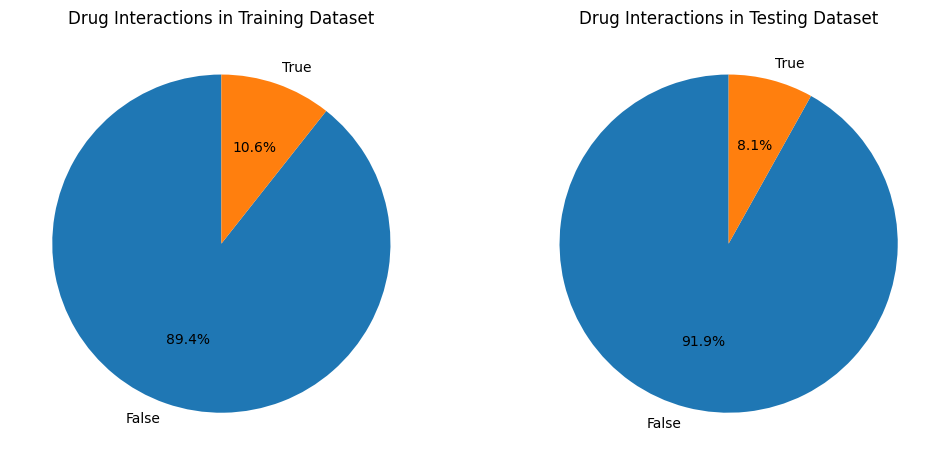

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].pie(interaction_counts, labels=interaction_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Drug Interactions in Training Dataset')


axs[1].pie(interaction_counts_test, labels=interaction_counts_test.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Drug Interactions in Testing Dataset')

plt.show()


## Visualisation

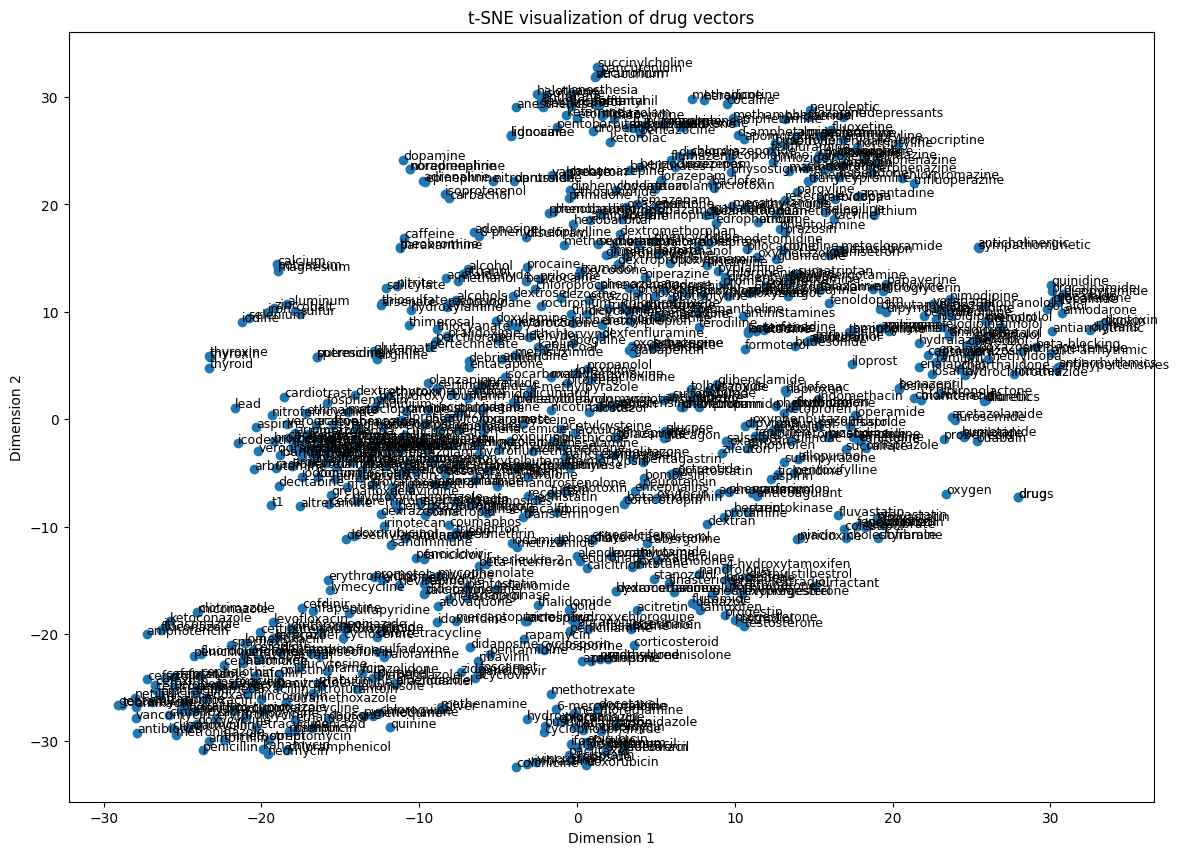

In [64]:
tsne = TSNE(n_components=2, random_state=42)
drug_vectors_2d = tsne.fit_transform(drug_vectors_df)

drug_vectors_2d_df = pd.DataFrame(drug_vectors_2d, index=drug_vectors_df.index, columns=['x', 'y'])

# Plot the 2D vectors
plt.figure(figsize=(14, 10))
plt.scatter(drug_vectors_2d_df['x'], drug_vectors_2d_df['y'])

# Annotate points with drug names
for drug, (x, y) in drug_vectors_2d_df.iterrows():
    plt.text(x, y, drug, fontsize=9)

plt.title('t-SNE visualization of drug vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## **Training**

### Logistic Regression, Decision Tree, Random Forest, SVM

Logistic Regression - Proportion 1:1 - Recall (Minority): 0.72 - Recall (Majority): 0.39
Accuracy: 0.41
              precision    recall  f1-score   support

           0       0.94      0.39      0.55      1317
           1       0.09      0.72      0.17       116

    accuracy                           0.41      1433
   macro avg       0.52      0.55      0.36      1433
weighted avg       0.87      0.41      0.52      1433

Decision Tree - Proportion 1:1 - Recall (Minority): 0.71 - Recall (Majority): 0.33
Accuracy: 0.36
              precision    recall  f1-score   support

           0       0.93      0.33      0.48      1317
           1       0.08      0.71      0.15       116

    accuracy                           0.36      1433
   macro avg       0.51      0.52      0.32      1433
weighted avg       0.86      0.36      0.46      1433

Random Forest - Proportion 1:1 - Recall (Minority): 0.86 - Recall (Majority): 0.26
Accuracy: 0.31
              precision    recall  f1-score   

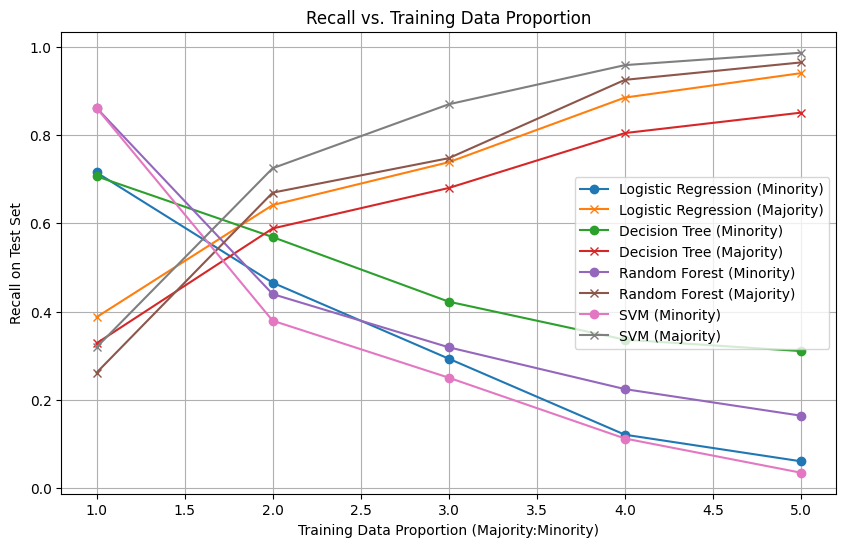

In [ ]:
# Filter out rows where Drug1 is the same as Drug2
drug_pairs_df = drug_pairs_df[drug_pairs_df['Drug1'] != drug_pairs_df['Drug2']]
drug_pairs_df_test = drug_pairs_df_test[drug_pairs_df_test['Drug1'] != drug_pairs_df_test['Drug2']]

# Function to combine vectors
def combine_vectors(row):
    drug1_vector = row['Drug1_Vector'] if row['Drug1_Vector'] is not None else []
    drug2_vector = row['Drug2_Vector'] if row['Drug2_Vector'] is not None else []
    return list(drug1_vector) + list(drug2_vector)

# Apply the function to create combined vectors
drug_pairs_df['Combined_Vector'] = drug_pairs_df.apply(combine_vectors, axis=1)
drug_pairs_df_test['Combined_Vector'] = drug_pairs_df_test.apply(combine_vectors, axis=1)

# Prepare the feature matrix and labels
X_train_full = list(drug_pairs_df['Combined_Vector'])
y_train_full = list(drug_pairs_df['Interaction_Label'])

X_test = list(drug_pairs_df_test['Combined_Vector'])
y_test = list(drug_pairs_df_test['Interaction_Label'])

# Handle imbalanced data
proportions = [1, 2, 3, 4, 5]  # Example proportions
recalls = []

for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = [X_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 1]
    y_minority = [y_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 1]
    
    X_majority = [X_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 0]
    y_majority = [y_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 0]
    
    # Sample majority class to balance the dataset
    

    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority = X_majority[:n_majority]
    y_majority = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = X_minority + X_majority
    y_train_balanced = y_minority + y_majority
    
    # Shuffle the data to ensure random distribution
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC()
    }
    
    for model_name, model in models.items():
        # Train the model on the balanced subset
        model.fit(X_train_balanced, y_train_balanced)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Evaluate the model using recall for both classes
        recall_minority = recall_score(y_test, y_pred, pos_label=1)
        recall_majority = recall_score(y_test, y_pred, pos_label=0)
        recalls.append((model_name, proportion, recall_minority, recall_majority))
        print(f"{model_name} - Proportion {proportion}:1 - Recall (Minority): {recall_minority:.2f} - Recall (Majority): {recall_majority:.2f}")
        
        # Optional: print additional metrics
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for each model
plt.figure(figsize=(10, 6))
for model_name in models.keys():
    model_recalls_minority = [recall_minority for name, proportion, recall_minority, recall_majority in recalls if name == model_name]
    model_recalls_majority = [recall_majority for name, proportion, recall_minority, recall_majority in recalls if name == model_name]
    plt.plot(proportions, model_recalls_minority, marker='o', label=f"{model_name} (Minority)")
    plt.plot(proportions, model_recalls_majority, marker='x', label=f"{model_name} (Majority)")

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion")
plt.legend()
plt.grid(True)
plt.show()

## XgBoost

c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 1:1 - Recall Class 1: 0.81, Recall Class 0: 0.29
Accuracy: 0.33
              precision    recall  f1-score   support

           0       0.95      0.29      0.44      1317
           1       0.09      0.81      0.16       116

    accuracy                           0.33      1433
   macro avg       0.52      0.55      0.30      1433
weighted avg       0.88      0.33      0.42      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 2:1 - Recall Class 1: 0.53, Recall Class 0: 0.64
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1317
           1       0.11      0.53      0.19       116

    accuracy                           0.63      1433
   macro avg       0.53      0.58      0.48      1433
weighted avg       0.87      0.63      0.72      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 3:1 - Recall Class 1: 0.50, Recall Class 0: 0.72
Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1317
           1       0.14      0.50      0.22       116

    accuracy                           0.70      1433
   macro avg       0.54      0.61      0.52      1433
weighted avg       0.88      0.70      0.77      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 4:1 - Recall Class 1: 0.27, Recall Class 0: 0.90
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1317
           1       0.19      0.27      0.22       116

    accuracy                           0.85      1433
   macro avg       0.56      0.58      0.57      1433
weighted avg       0.87      0.85      0.86      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 5:1 - Recall Class 1: 0.18, Recall Class 0: 0.94
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1317
           1       0.22      0.18      0.20       116

    accuracy                           0.88      1433
   macro avg       0.58      0.56      0.57      1433
weighted avg       0.87      0.88      0.88      1433



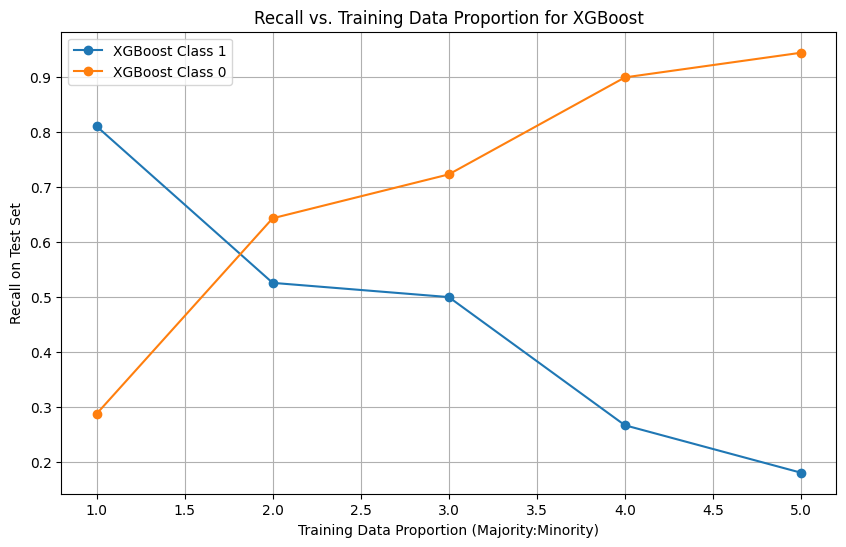

In [66]:
# Drop rows where both Drug1 and Drug2 are the same
drug_pairs_df = drug_pairs_df[drug_pairs_df['Drug1'] != drug_pairs_df['Drug2']]
drug_pairs_df_test = drug_pairs_df_test[drug_pairs_df_test['Drug1'] != drug_pairs_df_test['Drug2']]

# Combine the vectors of Drug1 and Drug2 into a single feature vector
def combine_vectors(row):
    drug1_vector = row['Drug1_Vector'] if row['Drug1_Vector'] is not None else []
    drug2_vector = row['Drug2_Vector'] if row['Drug2_Vector'] is not None else []
    return list(drug1_vector) + list(drug2_vector)

drug_pairs_df['Combined_Vector'] = drug_pairs_df.apply(combine_vectors, axis=1)
drug_pairs_df_test['Combined_Vector'] = drug_pairs_df_test.apply(combine_vectors, axis=1)

# Prepare the feature matrix and labels
X_train_full = list(drug_pairs_df['Combined_Vector'])
y_train_full = list(drug_pairs_df['Interaction_Label'])

X_test = list(drug_pairs_df_test['Combined_Vector'])
y_test = list(drug_pairs_df_test['Interaction_Label'])

# Handle imbalanced data
proportions = [1, 2, 3, 4, 5]  # Example proportions
recalls = []

for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = [X_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 1]
    y_minority = [y_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 1]
    
    X_majority = [X_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 0]
    y_majority = [y_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority = X_majority[:n_majority]
    y_majority = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = X_minority + X_majority
    y_train_balanced = y_minority + y_majority
    
    # Shuffle the data to ensure random distribution
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Train an XGBoost model on the balanced subset
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model using recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"XGBoost - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for XGBoost
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='XGBoost Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='XGBoost Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for XGBoost")
plt.legend()
plt.grid(True)
plt.show()

### Using Anomaly Detection Models

In [67]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Combine the vectors of Drug1 and Drug2 into a single feature vector
def combine_vectors(row):
    drug1_vector = row['Drug1_Vector'] if row['Drug1_Vector'] is not None else []
    drug2_vector = row['Drug2_Vector'] if row['Drug2_Vector'] is not None else []
    return list(drug1_vector) + list(drug2_vector)

drug_pairs_df['Combined_Vector'] = drug_pairs_df.apply(combine_vectors, axis=1)
drug_pairs_df_test['Combined_Vector'] = drug_pairs_df_test.apply(combine_vectors, axis=1)

# Prepare the feature matrix and labels
X_train = np.array(list(drug_pairs_df['Combined_Vector']))
y_train = np.array(drug_pairs_df['Interaction_Label'])

X_test = np.array(list(drug_pairs_df_test['Combined_Vector']))
y_test = np.array(drug_pairs_df_test['Interaction_Label'])

# Separate the majority class (normal) and minority class (anomalies)
X_train_normal = X_train[y_train == 0]
X_train_anomalies = X_train[y_train == 1]

# Train Isolation Forest
iso_forest = IsolationForest(contamination=len(X_train_anomalies)/len(X_train))
iso_forest.fit(X_train_normal)

# Train One-Class SVM
oc_svm = OneClassSVM(nu=len(X_train_anomalies)/len(X_train), kernel='rbf', gamma=0.1)
oc_svm.fit(X_train_normal)

# Predict using Isolation Forest
y_pred_iso_forest = iso_forest.predict(X_test)
y_pred_iso_forest = np.where(y_pred_iso_forest == 1, 0, 1)  # Convert 1 to 0 (normal) and -1 to 1 (anomaly)

# Predict using One-Class SVM
y_pred_oc_svm = oc_svm.predict(X_test)
y_pred_oc_svm = np.where(y_pred_oc_svm == 1, 0, 1)  # Convert 1 to 0 (normal) and -1 to 1 (anomaly)

# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    print(classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_iso_forest, "Isolation Forest")
evaluate_model(y_test, y_pred_oc_svm, "One-Class SVM")

Isolation Forest - Accuracy: 0.85, Precision: 0.09, Recall: 0.09, F1-Score: 0.09
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1317
           1       0.09      0.09      0.09       116

    accuracy                           0.85      1433
   macro avg       0.51      0.51      0.51      1433
weighted avg       0.85      0.85      0.85      1433

One-Class SVM - Accuracy: 0.27, Precision: 0.09, Recall: 0.91, F1-Score: 0.17
              precision    recall  f1-score   support

           0       0.96      0.22      0.35      1317
           1       0.09      0.91      0.17       116

    accuracy                           0.27      1433
   macro avg       0.53      0.56      0.26      1433
weighted avg       0.89      0.27      0.34      1433



### Neural Network 

In [68]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Combine the vectors of Drug1 and Drug2 into a single feature vector
def combine_vectors(row):
    drug1_vector = row['Drug1_Vector'] if row['Drug1_Vector'] is not None else []
    drug2_vector = row['Drug2_Vector'] if row['Drug2_Vector'] is not None else []
    return list(drug1_vector) + list(drug2_vector)

drug_pairs_df['Combined_Vector'] = drug_pairs_df.apply(combine_vectors, axis=1)
drug_pairs_df_test['Combined_Vector'] = drug_pairs_df_test.apply(combine_vectors, axis=1)

# Prepare the feature matrix and labels
X_test = np.array(list(drug_pairs_df_test['Combined_Vector']))
y_test = np.array(drug_pairs_df_test['Interaction_Label'])

# Define the neural network model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Handle imbalanced data
proportions = [1.5, 2, 2.5, 3]
metrics = []

for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = [X_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 1]
    y_minority = [y_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 1]
    
    X_majority = [X_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 0]
    y_majority = [y_train_full[i] for i in range(len(y_train_full)) if y_train_full[i] == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = int(n_minority * proportion)
    X_majority = X_majority[:n_majority]
    y_majority = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = X_minority + X_majority
    y_train_balanced = y_minority + y_majority
    
    # Shuffle the data to ensure random distribution
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Convert to numpy arrays
    X_train_balanced = np.array(X_train_balanced)
    y_train_balanced = np.array(y_train_balanced)
    
    # Create and train the model
    model = create_model(input_dim=X_train_balanced.shape[1])
    model.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=32, validation_split=0.2)
    
    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate the model using multiple metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics.append({
        'proportion': proportion,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })
    
    print(f"Proportion {proportion}:1 - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Print all metrics
print("Metrics for different proportions:")
for metric in metrics:
    print(metric)

c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5512 - loss: 0.8979 - val_accuracy: 0.6938 - val_loss: 0.5925
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6050 - loss: 0.6825 - val_accuracy: 0.7430 - val_loss: 0.5619
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6676 - loss: 0.6079 - val_accuracy: 0.7537 - val_loss: 0.5149
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6973 - loss: 0.5648 - val_accuracy: 0.7901 - val_loss: 0.4847
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7541 - loss: 0.5118 - val_accuracy: 0.8094 - val_loss: 0.4580
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7783 - loss: 0.4762 - val_accuracy: 0.8051 - val_loss: 0.4431
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7521 - loss: 0.4890 - val_accuracy: 0.8094 - val_loss: 0.4271
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 0.4393 - val_accuracy: 0.8051 - val_loss:

c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5761 - loss: 0.8813 - val_accuracy: 0.7380 - val_loss: 0.5731
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 0.6266 - val_accuracy: 0.7451 - val_loss: 0.5467
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7072 - loss: 0.5845 - val_accuracy: 0.7611 - val_loss: 0.5251
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7245 - loss: 0.5583 - val_accuracy: 0.7594 - val_loss: 0.5044
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7423 - loss: 0.5264 - val_accuracy: 0.7665 - val_loss: 0.4914
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7512 - loss: 0.5202 - val_accuracy: 0.7807 - val_loss: 0.4844
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.4876 - val_accuracy: 0.7790 - val_loss: 0.4540
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7700 - loss: 0.4770 - val_accuracy: 0.7843 - val_loss: 0.4437
Epo

c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6385 - loss: 0.8797 - val_accuracy: 0.7584 - val_loss: 0.5557
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7022 - loss: 0.6123 - val_accuracy: 0.7722 - val_loss: 0.5306
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7406 - loss: 0.5676 - val_accuracy: 0.7722 - val_loss: 0.5098
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7330 - loss: 0.5446 - val_accuracy: 0.7890 - val_loss: 0.4865
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.4968 - val_accuracy: 0.7951 - val_loss: 0.4798
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7739 - loss: 0.4973 - val_accuracy: 0.8012 - val_loss: 0.4562
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7895 - loss: 0.4743 - val_accuracy: 0.7890 - val_loss: 0.4411
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8160 - loss: 0.4254 - val_accuracy: 0.7997 - val_loss: 0.4398
Epo

c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6910 - loss: 0.6981 - val_accuracy: 0.7861 - val_loss: 0.5123
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7389 - loss: 0.5699 - val_accuracy: 0.8128 - val_loss: 0.5041
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7544 - loss: 0.5303 - val_accuracy: 0.8035 - val_loss: 0.4751
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7894 - loss: 0.4961 - val_accuracy: 0.8142 - val_loss: 0.4567
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.4701 - val_accuracy: 0.8155 - val_loss: 0.4422
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4511 - val_accuracy: 0.8302 - val_loss: 0.4272
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.4493 - val_accuracy: 0.8262 - val_loss: 0.4094
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.4192 - val_accuracy: 0.8222 - val_loss: 0.4007
Epo

In [69]:
drug_pairs_df
# drop the interacting column and combined vector column
drug_pairs_df = drug_pairs_df.drop(columns=['Interacting', 'Combined_Vector'])
drug_pairs_df_test = drug_pairs_df_test.drop(columns=['Interacting', 'Combined_Vector'])



In [70]:
# now put each element in the vector in a seperate column
drug_pairs_df = pd.concat([drug_pairs_df, pd.DataFrame(drug_pairs_df['Drug1_Vector'].tolist(), index=drug_pairs_df.index)], axis=1)
drug_pairs_df = pd.concat([drug_pairs_df, pd.DataFrame(drug_pairs_df['Drug2_Vector'].tolist(), index=drug_pairs_df.index)], axis=1)

drug_pairs_df_test = pd.concat([drug_pairs_df_test, pd.DataFrame(drug_pairs_df_test['Drug1_Vector'].tolist(), index=drug_pairs_df_test.index)], axis=1)
drug_pairs_df_test = pd.concat([drug_pairs_df_test, pd.DataFrame(drug_pairs_df_test['Drug2_Vector'].tolist(), index=drug_pairs_df_test.index)], axis=1)

drug_pairs_df

# drop the drug1_vector and drug2_vector columns
drug_pairs_df = drug_pairs_df.drop(columns=['Drug1_Vector', 'Drug2_Vector'])
drug_pairs_df_test = drug_pairs_df_test.drop(columns=['Drug1_Vector', 'Drug2_Vector'])

drug_pairs_df

Drug1               Drug2  Interaction_Label         0  \
56     azathioprine         chloroquine                  0 -1.758114   
57     azathioprine                gold                  0 -1.758114   
58     azathioprine  hydroxychloroquine                  0 -1.758114   
59     azathioprine         leflunomide                  0 -1.758114   
60     azathioprine       sulfasalazine                  0 -1.758114   
...             ...                 ...                ...       ...   
27781    atracurium          gentamycin                  0 -0.596157   
27782    atracurium          gentamycin                  1 -0.596157   
27783    gentamycin          atracurium                  1 -3.880826   
27784     temazepam             ethanol                  1 -1.570436   
27789     temazepam             ethanol                  1 -1.570436   

              1         2         3         4         5         6  ...  \
56     1.765694 -0.809791 -0.463783 -0.266910 -2.708471 -2.522802  ...   
57     1.765694 -0.809791 -0.463783 -0.266910 -2.708471 -2.522802  ...   
58     1.765694 -0.809791 -0.463783 -0.266910 -2.708471 -2.522802  ...   
59     1.765694 -0.809791 -0.463783 -0.266910 -2.708471 -2.522802  ...   
60     1.765694 -0.809791 -0.463783 -0.266910 -2.708471 -2.522802  ...   
...         ...       ...       ...       ...       ...       ...  ...   
27781  0.768044  0.100068  0.445121 -0.348493 -0.423195 -0.691468  ...   
27782  0.768044  0.100068  0.445121 -0.348493 -0.423195 -0.691468  ...   
27783  3.044013 -0.279876  1.860366  0.554343 -1.678261  1.669158  ...   
27784 -0.409908  1.008917 -1.119097  0.743915 -1.381125  0.803105  ...   
27789 -0.409908  1.008917 -1.119097  0.743915 -1.381125  0.803105  ...   

             90        91        92        93        94        95        96  \
56     0.609182 -1.103451 -0.674822  0.447816 -1.713301  4.287992 -1.402226   
57    -0.729576  0.364601  2.710251 -0.833248  1.185086  1.631089 -0.814780   
58    -0.275613 -0.838406  0.843947  0.213685  0.384436  1.972222 -0.349594   
59     0.662011 -0.680997 -0.601133  0.480509 -0.333032  0.075027  0.277612   
60     0.010073 -0.144867  0.196258  0.794556  1.154247  1.096374 -2.615438   
...         ...       ...       ...       ...       ...       ...       ...   
27781  0.512056 -0.594453  1.091237 -0.764489 -0.556747  0.720983  0.530436   
27782  0.512056 -0.594453  1.091237 -0.764489 -0.556747  0.720983  0.530436   
27783  1.003237 -0.423746  0.609023  0.229881 -0.473903  1.382695 -2.111334   
27784  2.523526  0.718531  1.174054 -0.620758 -1.036825  1.218856 -3.293271   
27789  2.523526  0.718531  1.174054 -0.620758 -1.036825  1.218856 -3.293271   

             97        98        99  
56     0.362941 -0.572616 -0.255392  
57     1.661161  1.535915 -0.144224  
58     0.379735 -0.623572  0.896211  
59     0.365707  0.632011  0.561221  
60     0.366685 -1.264366  0.142015  
...         ...       ...       ...  
27781  0.658089 -0.250704  0.805319  
27782  0.658089 -0.250704  0.805319  
27783 -1.018444 -0.552565  0.552426  
27784 -2.935991  0.644816  1.567771  
27789 -2.935991  0.644816  1.567771  

[8774 rows x 203 columns]

c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 1:1 - Recall Class 1: 0.81, Recall Class 0: 0.29
Accuracy: 0.33
              precision    recall  f1-score   support

           0       0.95      0.29      0.44      1317
           1       0.09      0.81      0.16       116

    accuracy                           0.33      1433
   macro avg       0.52      0.55      0.30      1433
weighted avg       0.88      0.33      0.42      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 2:1 - Recall Class 1: 0.53, Recall Class 0: 0.64
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1317
           1       0.11      0.53      0.19       116

    accuracy                           0.63      1433
   macro avg       0.53      0.58      0.48      1433
weighted avg       0.87      0.63      0.72      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 3:1 - Recall Class 1: 0.50, Recall Class 0: 0.72
Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1317
           1       0.14      0.50      0.22       116

    accuracy                           0.70      1433
   macro avg       0.54      0.61      0.52      1433
weighted avg       0.88      0.70      0.77      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 4:1 - Recall Class 1: 0.27, Recall Class 0: 0.90
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1317
           1       0.19      0.27      0.22       116

    accuracy                           0.85      1433
   macro avg       0.56      0.58      0.57      1433
weighted avg       0.87      0.85      0.86      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Proportion 5:1 - Recall Class 1: 0.18, Recall Class 0: 0.94
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1317
           1       0.22      0.18      0.20       116

    accuracy                           0.88      1433
   macro avg       0.58      0.56      0.57      1433
weighted avg       0.87      0.88      0.88      1433



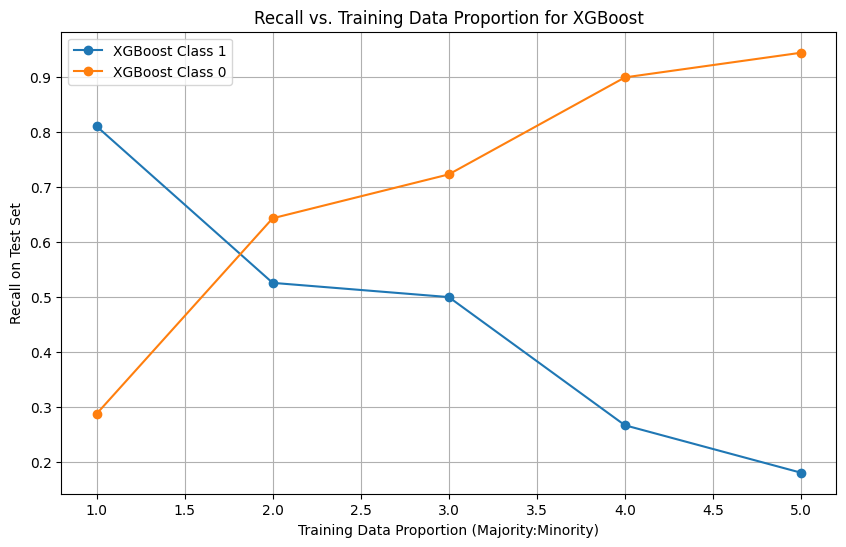

In [71]:
# Drop rows where both Drug1 and Drug2 are the same
drug_pairs_df = drug_pairs_df[drug_pairs_df['Drug1'] != drug_pairs_df['Drug2']]
drug_pairs_df_test = drug_pairs_df_test[drug_pairs_df_test['Drug1'] != drug_pairs_df_test['Drug2']]

# Select feature columns for both Drug1 and Drug2 vectors
# Assuming Drug1 vector columns start at index 4 and Drug2 at index 54 in your DataFrame
X_train_full = drug_pairs_df.iloc[:, 3:].values  # All vector columns
y_train_full = drug_pairs_df['Interaction_Label'].values

X_test = drug_pairs_df_test.iloc[:, 3:].values
y_test = drug_pairs_df_test['Interaction_Label'].values

# Handle imbalanced data
proportions = [1, 2, 3, 4, 5]  # Example proportions
recalls = []

for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = X_train_full[y_train_full == 1]
    y_minority = y_train_full[y_train_full == 1]
    
    X_majority = X_train_full[y_train_full == 0]
    y_majority = y_train_full[y_train_full == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority_sampled = X_majority[:n_majority]
    y_majority_sampled = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = np.vstack((X_minority, X_majority_sampled))
    y_train_balanced = np.concatenate((y_minority, y_majority_sampled))
    
    # Shuffle the data to ensure random distribution
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Train an XGBoost model on the balanced subset
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model using recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"XGBoost - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for XGBoost
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='XGBoost Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='XGBoost Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for XGBoost")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 1:1 - Recall Class 1: 0.78, Recall Class 0: 0.35
Accuracy: 0.38
              precision    recall  f1-score   support

           0       0.95      0.35      0.51      1317
           1       0.10      0.78      0.17       116

    accuracy                           0.38      1433
   macro avg       0.52      0.57      0.34      1433
weighted avg       0.88      0.38      0.48      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 2:1 - Recall Class 1: 0.47, Recall Class 0: 0.65
Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1317
           1       0.11      0.47      0.17       116

    accuracy                           0.64      1433
   macro avg       0.52      0.56      0.47      1433
weighted avg       0.87      0.64      0.72      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 3:1 - Recall Class 1: 0.56, Recall Class 0: 0.64
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1317
           1       0.12      0.56      0.20       116

    accuracy                           0.63      1433
   macro avg       0.53      0.60      0.48      1433
weighted avg       0.88      0.63      0.71      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 4:1 - Recall Class 1: 0.47, Recall Class 0: 0.81
Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1317
           1       0.18      0.47      0.26       116

    accuracy                           0.78      1433
   macro avg       0.56      0.64      0.56      1433
weighted avg       0.88      0.78      0.82      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 5:1 - Recall Class 1: 0.34, Recall Class 0: 0.88
Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1317
           1       0.20      0.34      0.25       116

    accuracy                           0.83      1433
   macro avg       0.57      0.61      0.58      1433
weighted avg       0.88      0.83      0.85      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 6:1 - Recall Class 1: 0.27, Recall Class 0: 0.91
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1317
           1       0.21      0.27      0.23       116

    accuracy                           0.86      1433
   macro avg       0.57      0.59      0.58      1433
weighted avg       0.87      0.86      0.87      1433



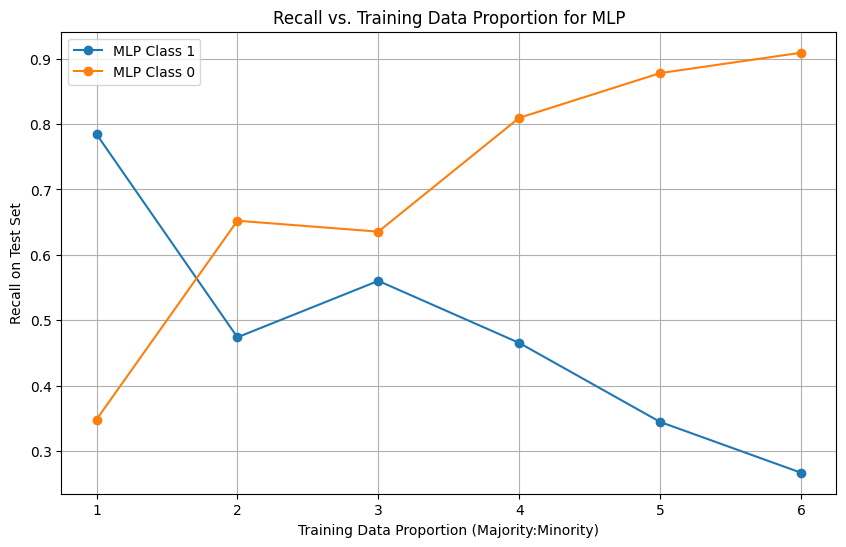

In [72]:
# Define a function to create the MLP model
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming Drug1 and Drug2 vectors combined result in 200 features
input_dim = 200  

# List to store recall results for each proportion
recalls = []

# Loop through different proportions for balancing
proportions = [1, 2, 3, 4, 5, 6]  # Example proportions
for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = X_train_full[y_train_full == 1]
    y_minority = y_train_full[y_train_full == 1]
    
    X_majority = X_train_full[y_train_full == 0]
    y_majority = y_train_full[y_train_full == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority_sampled = X_majority[:n_majority]
    y_majority_sampled = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = np.vstack((X_minority, X_majority_sampled))
    y_train_balanced = np.concatenate((y_minority, y_majority_sampled))
    
    # Shuffle the data
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Create and train the MLP model
    model = create_mlp_model(input_dim)
    model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, verbose=0)
    
    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"MLP - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for MLP
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='MLP Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='MLP Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for MLP")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 1:1 - Recall Class 1: 0.78, Recall Class 0: 0.36
Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.95      0.36      0.52      1317
           1       0.10      0.78      0.17       116

    accuracy                           0.39      1433
   macro avg       0.52      0.57      0.34      1433
weighted avg       0.88      0.39      0.49      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 2:1 - Recall Class 1: 0.47, Recall Class 0: 0.59
Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1317
           1       0.09      0.47      0.16       116

    accuracy                           0.58      1433
   macro avg       0.51      0.53      0.44      1433
weighted avg       0.86      0.58      0.68      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 3:1 - Recall Class 1: 0.54, Recall Class 0: 0.64
Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1317
           1       0.12      0.54      0.19       116

    accuracy                           0.64      1433
   macro avg       0.53      0.59      0.48      1433
weighted avg       0.87      0.64      0.72      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 4:1 - Recall Class 1: 0.34, Recall Class 0: 0.78
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1317
           1       0.12      0.34      0.18       116

    accuracy                           0.75      1433
   macro avg       0.53      0.56      0.52      1433
weighted avg       0.87      0.75      0.80      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MLP - Proportion 5:1 - Recall Class 1: 0.27, Recall Class 0: 0.90
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1317
           1       0.18      0.27      0.22       116

    accuracy                           0.84      1433
   macro avg       0.56      0.58      0.57      1433
weighted avg       0.87      0.84      0.86      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MLP - Proportion 6:1 - Recall Class 1: 0.21, Recall Class 0: 0.91
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1317
           1       0.17      0.21      0.19       116

    accuracy                           0.86      1433
   macro avg       0.55      0.56      0.56      1433
weighted avg       0.87      0.86      0.86      1433



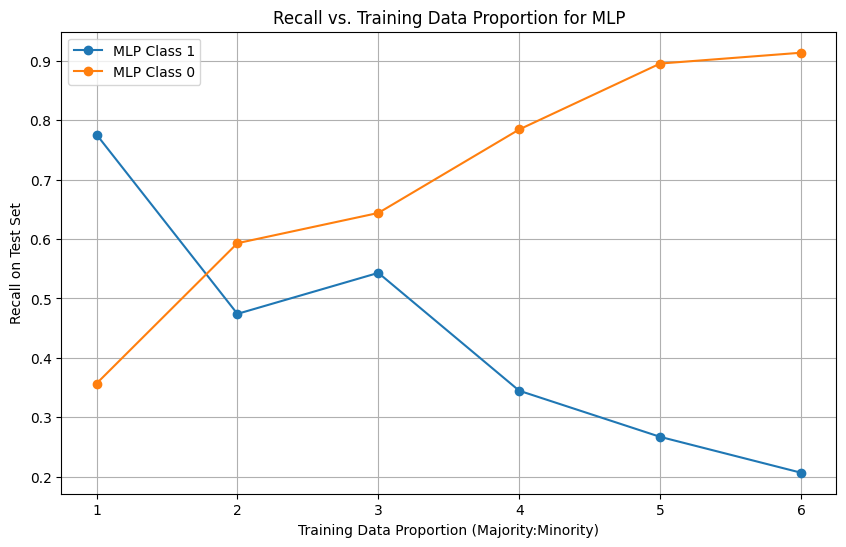

In [73]:
# Define a function to create the MLP model
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming Drug1 and Drug2 vectors combined result in 200 features
input_dim = 200  

# List to store recall results for each proportion
recalls = []

# Loop through different proportions for balancing
proportions = [1, 2, 3, 4, 5, 6]  # Example proportions
for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = X_train_full[y_train_full == 1]
    y_minority = y_train_full[y_train_full == 1]
    
    X_majority = X_train_full[y_train_full == 0]
    y_majority = y_train_full[y_train_full == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority_sampled = X_majority[:n_majority]
    y_majority_sampled = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = np.vstack((X_minority, X_majority_sampled))
    y_train_balanced = np.concatenate((y_minority, y_majority_sampled))
    
    # Shuffle the data
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Create and train the MLP model
    model = create_mlp_model(input_dim)
    model.fit(X_train_balanced, y_train_balanced, epochs=30, batch_size=32, verbose=0)
    

    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"MLP - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for MLP
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='MLP Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='MLP Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for MLP")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MLP - Proportion 1:1 - Recall Class 1: 0.85, Recall Class 0: 0.32
Accuracy: 0.37
              precision    recall  f1-score   support

           0       0.96      0.32      0.48      1317
           1       0.10      0.85      0.18       116

    accuracy                           0.37      1433
   macro avg       0.53      0.59      0.33      1433
weighted avg       0.89      0.37      0.46      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MLP - Proportion 2:1 - Recall Class 1: 0.58, Recall Class 0: 0.59
Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.94      0.59      0.73      1317
           1       0.11      0.58      0.19       116

    accuracy                           0.59      1433
   macro avg       0.53      0.59      0.46      1433
weighted avg       0.87      0.59      0.68      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MLP - Proportion 3:1 - Recall Class 1: 0.58, Recall Class 0: 0.61
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.94      0.61      0.74      1317
           1       0.12      0.58      0.19       116

    accuracy                           0.61      1433
   macro avg       0.53      0.60      0.47      1433
weighted avg       0.88      0.61      0.70      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MLP - Proportion 4:1 - Recall Class 1: 0.33, Recall Class 0: 0.84
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.93      0.84      0.89      1317
           1       0.16      0.33      0.21       116

    accuracy                           0.80      1433
   macro avg       0.55      0.59      0.55      1433
weighted avg       0.87      0.80      0.83      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 5:1 - Recall Class 1: 0.39, Recall Class 0: 0.80
Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1317
           1       0.15      0.39      0.21       116

    accuracy                           0.77      1433
   macro avg       0.54      0.59      0.54      1433
weighted avg       0.87      0.77      0.81      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 6:1 - Recall Class 1: 0.30, Recall Class 0: 0.89
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1317
           1       0.20      0.30      0.24       116

    accuracy                           0.84      1433
   macro avg       0.57      0.60      0.58      1433
weighted avg       0.88      0.84      0.86      1433



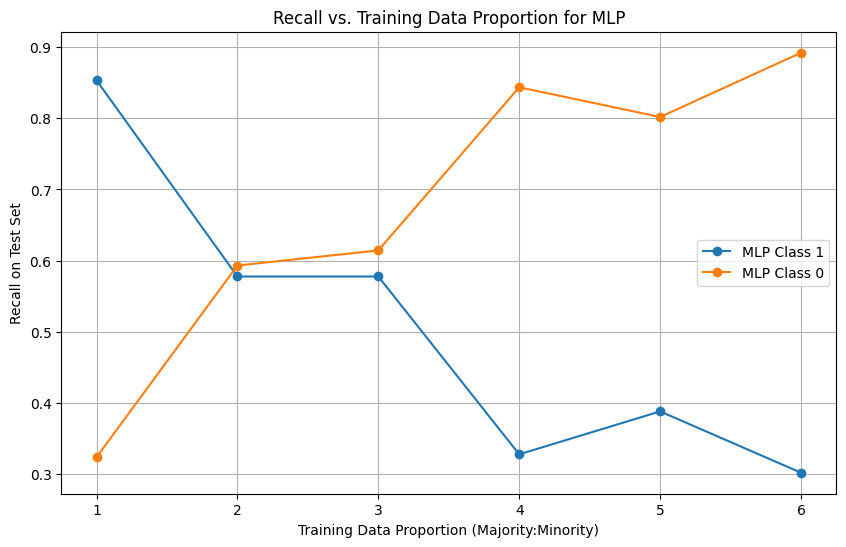

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Define a function to create the MLP model
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming Drug1 and Drug2 vectors combined result in 200 features
input_dim = 200  

# List to store recall results for each proportion
recalls = []

# Loop through different proportions for balancing
proportions = [1, 2, 3, 4, 5, 6]  # Example proportions
for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = X_train_full[y_train_full == 1]
    y_minority = y_train_full[y_train_full == 1]
    
    X_majority = X_train_full[y_train_full == 0]
    y_majority = y_train_full[y_train_full == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority_sampled = X_majority[:n_majority]
    y_majority_sampled = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = np.vstack((X_minority, X_majority_sampled))
    y_train_balanced = np.concatenate((y_minority, y_majority_sampled))
    
    # Shuffle the data
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Create and train the MLP model
    model = create_mlp_model(input_dim)
    model.fit(X_train_balanced, y_train_balanced, epochs=30, batch_size=32, verbose=0)
    
    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"MLP - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for MLP
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='MLP Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='MLP Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for MLP")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 1:1 - Recall Class 1: 0.70, Recall Class 0: 0.37
Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.93      0.37      0.53      1317
           1       0.09      0.70      0.16       116

    accuracy                           0.39      1433
   macro avg       0.51      0.53      0.34      1433
weighted avg       0.86      0.39      0.50      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 2:1 - Recall Class 1: 0.41, Recall Class 0: 0.67
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      1317
           1       0.10      0.41      0.16       116

    accuracy                           0.65      1433
   macro avg       0.51      0.54      0.47      1433
weighted avg       0.86      0.65      0.73      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 3:1 - Recall Class 1: 0.71, Recall Class 0: 0.60
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      1317
           1       0.13      0.71      0.23       116

    accuracy                           0.61      1433
   macro avg       0.55      0.65      0.48      1433
weighted avg       0.89      0.61      0.70      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 4:1 - Recall Class 1: 0.49, Recall Class 0: 0.77
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1317
           1       0.16      0.49      0.24       116

    accuracy                           0.75      1433
   macro avg       0.55      0.63      0.55      1433
weighted avg       0.88      0.75      0.80      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 5:1 - Recall Class 1: 0.36, Recall Class 0: 0.84
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      1317
           1       0.16      0.36      0.23       116

    accuracy                           0.80      1433
   macro avg       0.55      0.60      0.56      1433
weighted avg       0.87      0.80      0.83      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 6:1 - Recall Class 1: 0.33, Recall Class 0: 0.82
Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1317
           1       0.14      0.33      0.19       116

    accuracy                           0.78      1433
   macro avg       0.54      0.57      0.53      1433
weighted avg       0.87      0.78      0.82      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 7:1 - Recall Class 1: 0.23, Recall Class 0: 0.92
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1317
           1       0.20      0.23      0.21       116

    accuracy                           0.86      1433
   macro avg       0.56      0.57      0.57      1433
weighted avg       0.87      0.86      0.87      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Proportion 8:1 - Recall Class 1: 0.19, Recall Class 0: 0.93
Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1317
           1       0.19      0.19      0.19       116

    accuracy                           0.87      1433
   macro avg       0.56      0.56      0.56      1433
weighted avg       0.87      0.87      0.87      1433



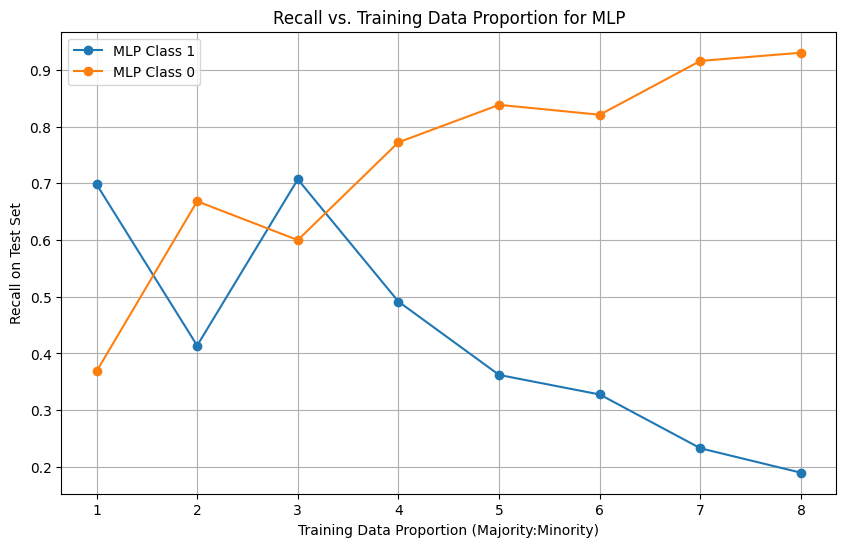

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Define a function to create the MLP model
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming Drug1 and Drug2 vectors combined result in 200 features
input_dim = 200  

# List to store recall results for each proportion
recalls = []

# Loop through different proportions for balancing
proportions = [1, 2, 3, 4, 5, 6, 7, 8]  # Example proportions
for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = X_train_full[y_train_full == 1]
    y_minority = y_train_full[y_train_full == 1]
    
    X_majority = X_train_full[y_train_full == 0]
    y_majority = y_train_full[y_train_full == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority_sampled = X_majority[:n_majority]
    y_majority_sampled = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = np.vstack((X_minority, X_majority_sampled))
    y_train_balanced = np.concatenate((y_minority, y_majority_sampled))
    
    # Shuffle the data
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Create and train the MLP model
    model = create_mlp_model(input_dim)
    model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, verbose=0)
    
    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Evaluate recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"MLP - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for MLP
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='MLP Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='MLP Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for MLP")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 1:1 - Recall Class 1: 0.76, Recall Class 0: 0.39
Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.95      0.39      0.56      1317
           1       0.10      0.76      0.18       116

    accuracy                           0.42      1433
   macro avg       0.52      0.58      0.37      1433
weighted avg       0.88      0.42      0.53      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 2:1 - Recall Class 1: 0.47, Recall Class 0: 0.65
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.93      0.65      0.77      1317
           1       0.11      0.47      0.17       116

    accuracy                           0.63      1433
   macro avg       0.52      0.56      0.47      1433
weighted avg       0.87      0.63      0.72      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 3:1 - Recall Class 1: 0.43, Recall Class 0: 0.68
Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.93      0.68      0.78      1317
           1       0.11      0.43      0.17       116

    accuracy                           0.66      1433
   macro avg       0.52      0.55      0.48      1433
weighted avg       0.86      0.66      0.73      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP - Proportion 4:1 - Recall Class 1: 0.35, Recall Class 0: 0.83
Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1317
           1       0.15      0.35      0.22       116

    accuracy                           0.79      1433
   macro avg       0.55      0.59      0.55      1433
weighted avg       0.87      0.79      0.83      1433



c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 7\IT-449\Drug-Drug-Interaction-and-Alternate-Recommendation-System\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP - Proportion 5:1 - Recall Class 1: 0.31, Recall Class 0: 0.88
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1317
           1       0.19      0.31      0.24       116

    accuracy                           0.84      1433
   macro avg       0.56      0.60      0.57      1433
weighted avg       0.88      0.84      0.85      1433



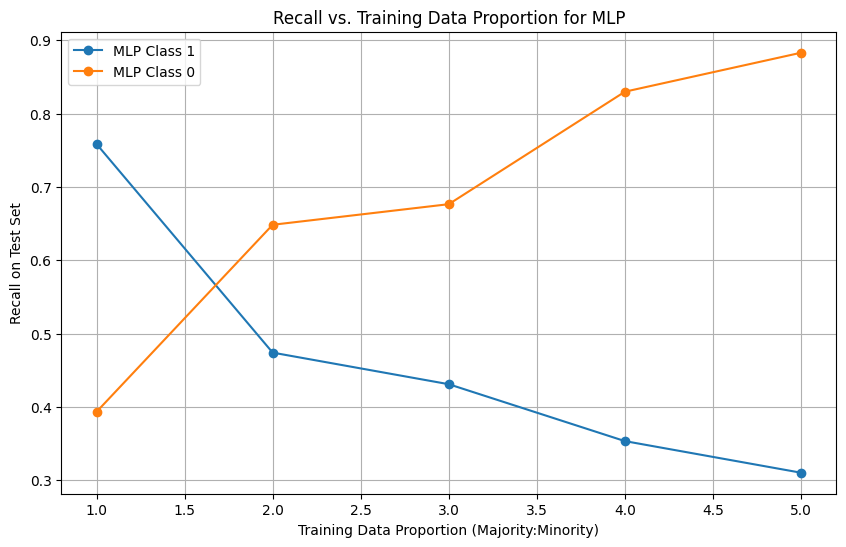

In [76]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf

def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(200, input_dim=input_dim, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Assuming the create_mlp_model function is defined and input_dim is 200
# Standardize features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# List to store recall results for each proportion
recalls = []

# Loop through different proportions for balancing
proportions = [1, 2, 3, 4, 5]

for proportion in proportions:
    # Separate majority and minority samples in the training set
    X_minority = X_train_full_scaled[y_train_full == 1]
    y_minority = y_train_full[y_train_full == 1]
    
    X_majority = X_train_full_scaled[y_train_full == 0]
    y_majority = y_train_full[y_train_full == 0]
    
    # Sample majority class to balance the dataset
    n_minority = len(X_minority)
    n_majority = n_minority * proportion
    X_majority_sampled = X_majority[:n_majority]
    y_majority_sampled = y_majority[:n_majority]
    
    # Combine the sampled majority and minority data
    X_train_balanced = np.vstack((X_minority, X_majority_sampled))
    y_train_balanced = np.concatenate((y_minority, y_majority_sampled))
    
    # Shuffle the data
    X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
    
    # Create and train the MLP model
    model = create_mlp_model(input_dim)
    model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, verbose=0)
    
    # Predict on the test set
    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    
    # Evaluate recall for both classes
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recalls.append((proportion, recall_class_1, recall_class_0))
    
    print(f"MLP - Proportion {proportion}:1 - Recall Class 1: {recall_class_1:.2f}, Recall Class 0: {recall_class_0:.2f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

# Plot Recall vs Training Data Proportion for MLP
plt.figure(figsize=(10, 6))
proportions, recall_scores_class_1, recall_scores_class_0 = zip(*recalls)
plt.plot(proportions, recall_scores_class_1, marker='o', label='MLP Class 1')
plt.plot(proportions, recall_scores_class_0, marker='o', label='MLP Class 0')

plt.xlabel("Training Data Proportion (Majority:Minority)")
plt.ylabel("Recall on Test Set")
plt.title("Recall vs. Training Data Proportion for MLP")
plt.legend()
plt.grid(True)
plt.show()
